Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Spring 2020

### Setup


In [2]:
# !pip uninstall opencv-python -y
# # downgrade OpenCV a bit to use SIFT
# !pip install opencv-contrib-python==3.4.2.17 --force-reinstall
# !pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt
# print("ok")

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [3]:
def score_projection(pt1, pt2):
    '''
    Score corresponding to the number of inliers for RANSAC
    Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
    Outputs: score (scalar count of inliers) and inliers (1xN logical array)
    '''
#     pt1: Xb[:2,:]/Xb[2,:]

#     pt2: Xb_[:2,:]/Xb_[2,:]

    temp1 = pt2[0,:] - pt1[0,:]
    temp2 = pt2[1,:] - pt1[1,:]
    
    temp_ok_t = np.sqrt(temp1**2 + temp2**2) < 1
    temp_score_t = sum(temp_ok_t)

    return temp_score_t, temp_ok_t


#     return score, inliers

In [4]:
def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib
    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))
    #update matches with the ones that have distances we desire
    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 500
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here

    
    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)
#         print("H_t.shape ", H_t.shape)
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
#     print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [5]:
def computeHomography(pts1, pts2, normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. 
    Normalization is optional.
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    #check 
    #https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog
    #http://ros-developer.com/2017/12/26/finding-homography-matrix-using-singular-value-decomposition-and-ransac-in-opencv-and-matlab/
    # TO DO
    
    _, dimN = pts1.shape
    A = np.zeros((2*dimN+1, 9), dtype = np.float32)
    
    for i in range (0, dimN): #dimN:4
        p = pts1[:,i]
        u = p[0]/p[2]
        v = p[1]/p[2]
        
        p_2 = pts2[:,i]
        u_2 = p_2[0]/p_2[2]
        v_2 = p_2[1]/p_2[2]

        A[i*2,:] = [-u,-v,-1,0,0,0,u*u_2, v*u_2, u_2]
        A[i*2+1,:] = [0,0,0,-u,-v,-1,u*v_2, v*v_2, v_2]
    A[8,:] = [0,0,0,0,0,0,0,0,1]
#     print("A.shape ", A.shape)
    _,_,result = svd(A)
    result_h = result[-1,:]
    result_H = np.reshape(result_h, (3, 3))
    

    return result_H


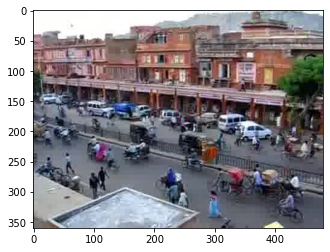

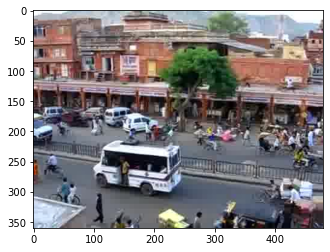

In [6]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)
#  switch color channels here
im1 = im1[:,:,[2,1,0]]
im2 = im2[:,:,[2,1,0]]
plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()

In [7]:
H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

[[ 1.0000000e+00  5.4045100e-02 -2.0543286e+02]
 [ 1.2389463e-02  9.5650631e-01 -1.5975067e+01]
 [ 3.7065562e-04  4.4416647e-05  8.1761378e-01]]


[[300 400 400 300 300]
 [100 100 200 200 100]
 [  1   1   1   1   1]]


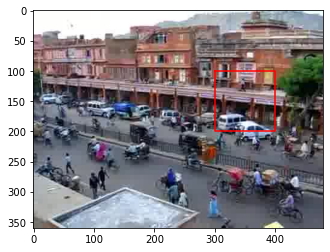

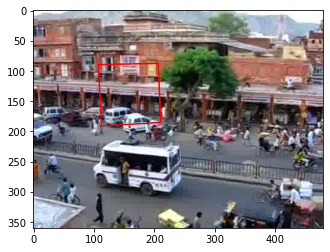

In [8]:
# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1)
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')
print(box_pts)


#apply previous H to the box
box_im2 = np.dot(H, box_pts)
# print(box_im2)
box_im2 = box_im2 / box_im2[-1]
# print(box_im2)
plt.figure()
plt.imshow(im2)
plt.plot(box_im2[0,:], box_im2[1, :], 'r-')

# # TO DO: project points into im2 and display the projected lines on im2



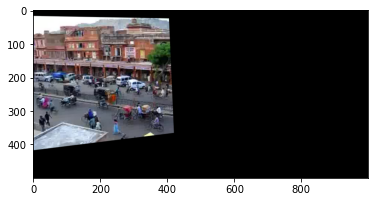

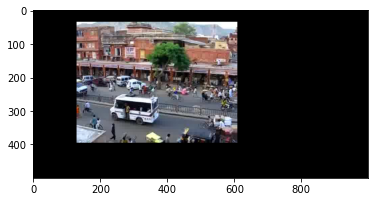

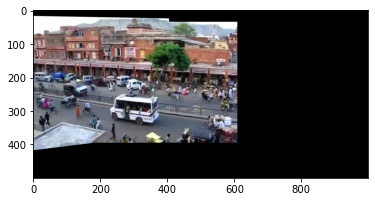

In [9]:
cols = 1000
rows = 500
img_rows = im1.shape[0] 
img_cols = im1.shape[1] 
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

# TO DO: warp and blend the two images
H_transition = np.identity(3)
H_transition[0,2] = (cols-img_cols)/4
H_transition[1,2] = (rows-img_rows)/4
# print(H_transition)

im2_rot = cv2.warpPerspective(im2,H_transition,(cols, rows))
#H用在这里！
im1_rot = cv2.warpPerspective(im1, np.dot(H_transition, H), (cols, rows))


plt.imshow(im1_rot)
plt.show()
plt.imshow(im2_rot)
plt.show()
result = utils.blendImages(im1_rot, im2_rot)
# result = im1_rot
# for i in range(0,rows):
#     for j in range(0,cols):
#         if (result[i,j].sum() == 0) and (im2_rot[i,j].sum() != 0):
#             result[i,j] = im2_rot[i,j]
# plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()



### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


In [10]:
def combine(result, im1, im2, H):
    row, col, _ = result.shape
    img_comb = cv2.warpPerspective(im1, np.dot(H_transition, H), (col, row))
    return utils.blendImages(img_comb, result)

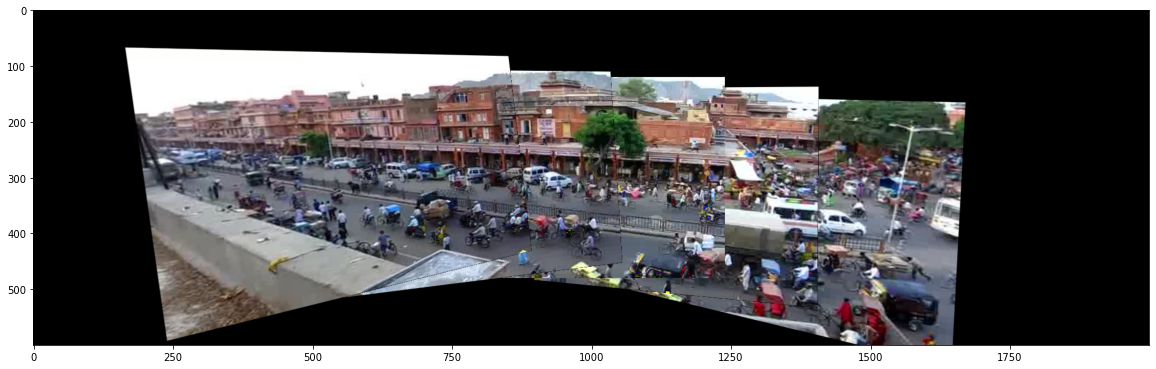

In [11]:
key_frames_idx = np.array([90, 270, 450, 630, 810])
reference_frame = 450
frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
    frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))
img90 = frames[0][:,:,[2,1,0]]
img270 = frames[1][:,:,[2,1,0]]
img450 = frames[2][:,:,[2,1,0]]
img630 = frames[3][:,:,[2,1,0]]
img810 = frames[4][:,:,[2,1,0]]


# plt.imshow(img90)  
# plt.show()
# plt.imshow(img270)  
# plt.show()
# plt.imshow(img450)  
# plt.show()

H90_270 = auto_homography(img90,img270, computeHomography)
H270_450 = auto_homography(img270,img450, computeHomography)
H630_450 = auto_homography(img630,img450, computeHomography)
H810_630 = auto_homography(img810,img630, computeHomography)


H90_450 = np.dot(H90_270, H270_450)
H810_450 = np.dot(H630_450,H810_630)

cols = 2000
rows = 600
H_transition = np.identity(3)
H_transition[0,2] = (cols-img_cols)/2
H_transition[1,2] = (rows-img_rows)/2


result = cv2.warpPerspective(img90 ,np.dot(H_transition, H90_450),(cols, rows))

combine(result,img270,img450,H270_450)
combine(result,img450,img450,np.identity(3))
combine(result,img630,img450,H630_450)
combine(result,img810,img450,H810_450)


plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()

### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [12]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)
    frames[idx] = frames[idx][:,:,[2,1,0]]
# plt.imshow(frames[0])  
# plt.show()

In [13]:
# #test1
# cols = 2000
# rows = 600
# key_frame_num = 450
# # for i in range(0, frameCount-1):
# for i in range(0, 10):
#     file1 = frames[i]
#     file2 = frames[key_frame_num]

#     img_rows = file1.shape[0] 
#     img_cols = file1.shape[1] 
# #     plt.imshow(file1)  
# #     plt.show()
# #     plt.imshow(file2)  
# #     plt.show()
#     H = auto_homography(file1,file2, computeHomography)
# #     print(H/H.max()) 
#     H_transition = np.identity(3)
#     H_transition[0,2] = (cols-img_cols)/4
#     H_transition[1,2] = (rows-img_rows)/4
#     file2_rot = cv2.warpPerspective(file2,H_transition,(cols, rows))
#     file1_rot = cv2.warpPerspective(file1, np.dot(H_transition, H), (cols, rows))
# #     result = utils.blendImages(file1_rot, file2_rot)
#     plt.imshow(file1_rot)
#     plt.show()


In [15]:
#test2
previous_H = [H90_450, H270_450, np.identity(3), H630_450,H810_450]
cols = 2000
rows = 600
# key_frame_num = 450
key_frames_idx = np.array([90, 270, 450, 630, 810])

part5_H= np.zeros((900,3,3,3))#to save the H for useage in part 5

for i in range(0, 900):
# for i in range(0, 10):
    if(i % 50 == 0):
        print("current i is: ", i)
    file1 = frames[i]
    closest_id = np.argmin(np.abs(i - key_frames_idx))
    key_frame_num = key_frames_idx[closest_id]

#     print("key_frame_num: ", key_frame_num)
    file2 = frames[key_frame_num]

    img_rows = file1.shape[0] 
    img_cols = file1.shape[1] 
#     plt.imshow(file1)  
#     plt.show()
#     plt.imshow(file2)  
#     plt.show()
    H = auto_homography(file1,file2, computeHomography)
#     print(H/H.max()) 
#     H_transition = np.identity(3)
#     H_transition[0,2] = (cols-img_cols)/4
#     H_transition[1,2] = (rows-img_rows)/4
    H_transition = np.dot(H, previous_H[closest_id])
    part5_H[i,:,:,:] =H_transition
#     file1_rot = cv2.warpPerspective(file1, np.dot(H_transition, H), (cols, rows))
#     file1_rot = cv2.warpPerspective(file1, Tr.dot(H_transition), (cols, rows))
    
#     result = utils.blendImages(file1_rot, file2_rot)
#     plt.imshow(file1_rot)
#     plt.show()

#     cv2.imwrite('images/input/frames_2/f{fileNumber}.jpg'.format(fileNumber = i), file1_rot[:,:,[2,1,0]])


current i is:  0
current i is:  50
current i is:  100
current i is:  150
current i is:  200
current i is:  250
current i is:  300
current i is:  350
current i is:  400
current i is:  450
current i is:  500
current i is:  550
current i is:  600
current i is:  650
current i is:  700
current i is:  750
current i is:  800
current i is:  850


In [52]:
#make video from the files
import utils
dir_frames2 = 'images/input/frames_2'
filenames = []
filesinfo = os.scandir(dir_frames2)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames2 = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')
# print(filenames)
for idx, file_i in enumerate(filenames):
    frames2[idx] = cv2.imread(file_i)
    frames2[idx] = frames2[idx][:,:,[2,1,0]]
# plt.imshow(frames[0])  
# plt.show()
fnOut = 'images/input/some_output_temp_1129.mpeg'

# print(frames.shape)
utils.imageFolder2mpeg(dir_frames2, fnOut, fps=30)
# utils.imageFolder2mpeg('./images/input/aligned_frames_100',output_path='./images/input/output_video_result100.mpeg', fps=30.0)
# utils.vidwrite_from_numpy(fnOut, frames2, framerate=30)

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [18]:
#use median
dir_frames = './images/input/frames_2'
filenames_p4 = []
filesinfo = os.scandir(dir_frames)

filenames_p4 = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames_p4.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
total_num = len(filenames_p4)

# print(filenames_p4)
height, width, _ = cv2.imread(filenames_p4[0]).shape
raw_backgrounds = np.zeros((total_num, height, width, 3),dtype=np.float32)


for idx, file_i in enumerate(filenames_p4):
    raw_backgrounds[idx] = cv2.imread(file_i)[:,:,[2,1,0]] / 255.0
#     plt.figure(figsize=(20,10))
#     plt.imshow(raw_backgrounds[idx])  
#     plt.show()
#     if(idx > 5):
#         break

print("raw_backgrounds ", raw_backgrounds.shape)

raw_backgrounds  (900, 600, 2000, 3)


In [19]:
background = np.zeros((height, width, 3))


In [20]:
for i in range (height):
    for j in range (width):
        for k in range(3):
            nonzero_collection = np.nonzero(raw_backgrounds[:, i, j, k])
            
            if len(nonzero_collection) != 0:
                #print(np.median(projected_frames[nonzero_collection, i, j, k]))
                background[i][j][k] = np.median(raw_backgrounds[nonzero_collection, i, j, k])

/Users/MedicalDoctor/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/MedicalDoctor/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(background)
plt.show()

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [ ]:
#part5_H form part 3



### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6


## Bells and whistles